In [2]:
import numpy as np
import os
import sys
import json
import pickle
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA

### Load

In [4]:
data = pickle.load( open("../../data/enron/pickle/processed.p", "rb"))
corpus = data['corpus']
labels = data['labels']
print(len(corpus))

33702


### Word Counts

In [5]:
D = {}
Dspam = {}
Dham = {}
for t,text in enumerate(corpus):
    words = text.split(' ')
    label = labels[t]
    for word in words:
        if word in D:
            count = D[word]
            D[word] = count + 1
        else:
            D[word] = 1

### Convert and Compute other metrics

In [9]:
counts = np.array(list(D.values()))
frequencies = counts / np.sum(counts)
keywords = np.array(list(D.keys()))
indices = np.argsort(frequencies)[::-1]
frequencies = frequencies[indices]
counts = counts[indices]
keywords = keywords[indices]

### Restrict 

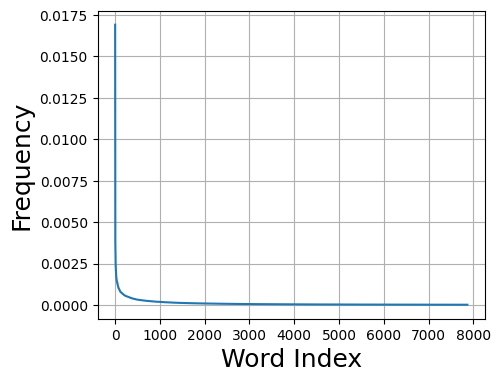

In [10]:
min_count = 50
indices = np.where(counts > min_count)[0]
keywords = keywords[indices]
frequencies = frequencies[indices]
counts = counts[indices]
plt.figure(figsize=(5,4));
plt.plot(frequencies);
plt.grid();
plt.xlabel('Word Index',fontsize=18);
plt.ylabel('Frequency',fontsize=18);

### Remove High Frequency Words

7787


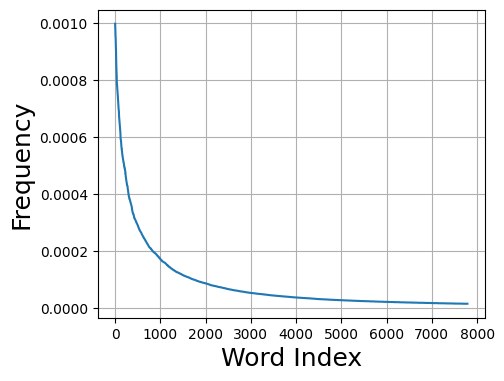

In [11]:
max_frequency = 0.001
indices = np.where(frequencies < max_frequency)[0]
keywords = keywords[indices]
frequencies = frequencies[indices]
counts = counts[indices]
plt.figure(figsize=(5,4));
plt.plot(frequencies);
plt.grid();
plt.xlabel('Word Index',fontsize=18);
plt.ylabel('Frequency',fontsize=18);
print(len(keywords))

### Compute apriori probabilities

In [12]:
no_total = len(labels)
no_spam = np.sum(labels)
no_ham = no_total - no_spam
prob_spam = no_spam / no_total
prob_ham = no_ham / no_total

### Compute Word Probabilities

In [13]:
prob_word = frequencies.copy()

### Count Words given Ham

In [14]:
labels = np.array(labels)
ham_indices = np.where(labels == 0)[0]
count_word_ham = np.zeros((prob_word.shape))
for index in tqdm(ham_indices):
    text = corpus[index]
    label = labels[index]
    words = text.split(' ')
    words = np.unique(words)
    for word in words:
        if word in keywords:
            index = np.where(keywords == word)[0][0]
            count_word_ham[index] = count_word_ham[index] + 1

100%|████████████████████████████████████| 16545/16545 [01:08<00:00, 241.48it/s]


### Count Words given Spam

In [15]:
labels = np.array(labels)
spam_indices = np.where(labels == 1)[0]
count_word_spam = np.zeros((prob_word.shape))
for index in tqdm(spam_indices):
    text = corpus[index]
    label = labels[index]
    words = text.split(' ')
    words = np.unique(words)
    for word in words:
        if word in keywords:
            index = np.where(keywords == word)[0][0]
            count_word_spam[index] = count_word_spam[index] + 1

100%|████████████████████████████████████| 17157/17157 [01:04<00:00, 265.41it/s]


### Normalize

In [22]:
prob_word_ham = count_word_ham / np.sum(count_word_ham)
prob_word_spam = count_word_spam / np.sum(count_word_spam)

### Collect Probabilities and keyword into model

In [23]:
model = {}
model['prob_spam'] = prob_spam
model['prob_ham'] = prob_ham
model['prob_word'] = prob_word
model['prob_word_ham'] = prob_word_ham
model['prob_word_spam'] = prob_word_spam
model['dictionary'] = keywords

### Predict Helper

In [24]:
def predict(text,model):
    
    #Unpack
    keywords = model['dictionary']
    prob_spam = model['prob_spam']
    prob_ham = model['prob_ham']
    prob_word = model['prob_word']
    prob_word_ham = model['prob_word_ham']
    prob_word_spam = model['prob_word_spam']
    
    #Loop Through Text
    words = text.split(' ')
    prob_ham_word = 1
    prob_spam_word = 1 
    for word in words:
        index = np.where(keywords == word)[0]
        if (len(index) > 0):
            index = index[0]
            prob_ham_word = prob_ham_word * ((prob_word_ham[index] * prob_ham) / prob_word[index])
            prob_spam_word = prob_spam_word * ((prob_word_spam[index] * prob_spam) / prob_word[index])
    prob_ham_word = prob_ham_word / (prob_ham_word + prob_spam_word)
    prob_spam_word = prob_spam_word / (prob_ham_word + prob_spam_word)
    
    #Return
    return prob_spam_word

### Predict

In [34]:
y_pred = []
y_pred_prob = []
for index in tqdm(range(len(corpus))):
    text = corpus[index]
    label = labels[index]
    prob = predict(text,model)
    pred = prob > 0.5
    y_pred.append(pred)
    y_pred_prob.append(prob)

  0%|                                       | 21/33702 [00:00<02:57, 189.77it/s]/var/folders/kg/gffcbs8j5472jdy53thpczsm0000gn/T/ipykernel_10656/341695379.py:21: RuntimeWarning: invalid value encountered in double_scalars
  prob_ham_word = prob_ham_word / (prob_ham_word + prob_spam_word)
100%|████████████████████████████████████| 33702/33702 [02:21<00:00, 237.97it/s]


In [37]:
y_pred_prob = np.array(y_pred_prob)
y_pred = np.array(y_pred)

In [40]:
np.sum(y_pred == labels) / len(labels)

0.967479674796748